# Apprenez une heuristique pour le Go

Dans ce **TP noté**, vous devrez déployer des methodes d'apprentissage automatique permettant d'évaluer la qualité de plateaux de GO.

Pour cela, vous disposerez de 21854 exemples de plateau de Go, tous générés par `gnugo` après quelques coups contre lui même avec un niveau de difficulté de 0. Par chaque plateau, nous avons lancé 100 matchs de gnugo contre lui même, toujours avec un niveau 0, et compté le nombre de victoires de noir et de blanc depuis ce plateau.

A noter, chaque "rollout" (un rollout et un déroulement possible du match depuis le plateau de référence) correspond à des mouvements choisis aléatoirement parmis les 10 meilleurs mouvements possibles, en biasant le choix aléatoire par la qualité prédite du mouvement par gnugo (les meilleurs mouvements ont une plus forte probabilité d'être tirés).

Les données dont vous disposez sont brutes. Ce sera à vous de proposer un format adéquat pour utiliser ces données en entrée de votre réseau neuronal.


## Comment sera évalué votre modèle ?

Nous vous fournirons 6h avant la date de rendu un nouveau fichier contenant 1000 nouveaux exemples, qui ne contiendront pas les champs `black_wins`, `white_wins`, `black_points` et `white_points`. Vous devrez laisser, dans votre dépot de projet (votre dépot GIT sous un sous-répertoire ML) un fichier texte nommé `my_predictions.txt` ayant une prédiction par ligne (un simple flottant) qui donnera, dans le même ordre de la liste des exemples les scores que vous prédisez pour chacune des entrées du fichier que nous vous aurons donné. ** Les scores seront donnés sous forme d'un flottant, entre 0 et 1, donnant la probabilité de victoire de noir sur le plateau considéré **. Il faudra laisser, dans votre feuille notebook (voir tout en dessous) la cellule Python qui aura créé ce fichier, pour que l'on puisse éventuellement refaire vos prédictions.

Bien entendu, vous nous rendrez également votre feuille jupyter **sous deux formats**, à la fois le fichier `.ipynb` et le fichier `.html` nous permettant de lire ce que vous avez fait, sans forcément relancer la feuille. Nous prendrons en compte les résultats obtenus sur les prédictions mais aussi le contenu de vos notebooks jupyter.

### Comment sera noté ce TP ?

**Il s'agit d'un TP noté (et non pas d'un projet), donc il ne faudra pas y passer trop de temps**. Nous attendons des prédictions correctes mais surtout des choix justifiés dans la feuille. Votre feuille notebook sera le plus important pour la notation (n'hésitez pas à mettre des cellules de texte pour expliquer pourquoi vous avez été amenés à faire certains choix). Ainsi, il serait bien d'avoir, par exemple, les données (graphiques ou autre) qui permettent de comprendre comment vous avez évité l'overfitting.

Le fichier de vos prédiction sera évalué en se basant sur la qualité de vos prédictions. Nous mesurerons par exemple (juste pour vous donner une idée) le nombre d'exemples dont votre prédiction donnera la bonne valeur à 5%, 10%, 20%, 35%, 50% pour estimer sa qualité.


## Mise en route !

Voyons  comment lire les données


In [1]:
# Import du fichier d'exemples

def get_raw_data_go():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "samples-8x8.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/static/inge2-ia/samples-8x8.json.gz", "samples-8x8.json.gz")
        print(" Done")

    with gzip.open("samples-8x8.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go()
print("We have", len(data),"examples")

We have 41553 examples


## Compréhension des données de chaque entrée

Voici une description de chaque exemple

In [2]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Données brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

summary_of_example(data,10)

Sample 10

Données brutes en format JSON: {'depth': 39, 'list_of_moves': ['E5', 'C5', 'D3', 'F6', 'E3', 'E6', 'F5', 'D6', 'G6', 'G7', 'B4', 'C4', 'G5', 'B5', 'C3', 'B3', 'B2', 'A4', 'D4', 'A2', 'C1', 'H7', 'B1', 'A3', 'H6', 'D5', 'A1', 'F7', 'D2', 'E8', 'E4', 'E7', 'F2', 'G8', 'F3', 'A5', 'G4', 'PASS', 'H4'], 'black_stones': ['G6', 'H6', 'E5', 'F5', 'G5', 'D4', 'E4', 'G4', 'H4', 'C3', 'D3', 'E3', 'F3', 'B2', 'D2', 'F2', 'A1', 'B1', 'C1'], 'white_stones': ['E8', 'G8', 'E7', 'F7', 'G7', 'H7', 'D6', 'E6', 'F6', 'A5', 'B5', 'C5', 'D5', 'A4', 'C4', 'A3', 'B3', 'A2'], 'rollouts': 100, 'black_wins': 0, 'black_points': 0, 'white_wins': 0, 'white_points': 0}

The sample was obtained after 39 moves
The successive moves were ['E5', 'C5', 'D3', 'F6', 'E3', 'E6', 'F5', 'D6', 'G6', 'G7', 'B4', 'C4', 'G5', 'B5', 'C3', 'B3', 'B2', 'A4', 'D4', 'A2', 'C1', 'H7', 'B1', 'A3', 'H6', 'D5', 'A1', 'F7', 'D2', 'E8', 'E4', 'E7', 'F2', 'G8', 'F3', 'A5', 'G4', 'PASS', 'H4']
After these moves and all the captures,

## Données en entrée et en sortie de votre modèle final

Même si en interne, votre modèle va manipuler des tenseurs en numpy, vous devrez construire une boite noire qui prendra en entrée les données dans le style du JSON ci-dessous. Typiquement, vous aurez le même genre de fichier avec seulement les champs `black_stones`, `white_stones`, `depth` et `list_of_moves` de renseignées. Vous devrez utiliser ces champs, dont notemment les coordonnées des pierres noires et blanches et donner le pourcentage de chance pour noir de gagner depuis cette position.

Ainsi, pour l'exemple `i` :
- Vous pourrez prendez en entree `data[i]["black_stones"]` et `data[i]["white_stones"]` (vous pouvez, si vous le souhaitez, prendre en compte également `list_of_moves` ou tout autre donnée que vous calculerez vous-même (mais qui ne se basera évidemment pas sur les données que vous n'aurez pas lors de l'évaluation).
- Vous devrez prédire simplement `data[i]["black_wins"]/data[i]["rollouts"]` en float (donc une valeur entre 0 et 1).

Encore une fois, **attention** : en interne, il faudra absolument construire vos données formattées en matrices numpy pour faire votre entrainement. On vous demande juste ici d'écrire comment vous faites ces transformations, pour comprendre ce que vous avez décidé de mettre en entrée du réseau.

Voici par exemple le modèle de la fonction qui pourra être appelée, au final :


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from keras.models import load_model

# Assume ConvNet and other functions (get_data, name_to_coord) are already defined as provided earlier

# Load the Keras model (assuming it was trained and saved as 'my_model.h5')
model = torch.load('death.pth')

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}
    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

def prepare_input(black_stones, white_stones):
    x = np.zeros((2, 8, 8))
    for stone in black_stones:
        col, lin = name_to_coord(stone)
        x[0, col, lin] = 1
    for stone in white_stones:
        col, lin = name_to_coord(stone)
        x[1, col, lin] = 1
    return x

def position_predict(black_stones, white_stones):
    # Préparer les données d'entrée
    x = prepare_input(black_stones, white_stones)
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # Ajouter une dimension pour le batch

    # Faire une prédiction avec le modèle PyTorch
    with torch.no_grad():
        prediction = model(x)
    
    return prediction
# Par exemple, nous pourrons appeler votre prédiction ainsi

print("Prediction this sample:")
summary_of_example(data, 10)
print()
prediction = position_predict(data[10]["black_stones"], data[10]["white_stones"])
print("You predicted", prediction, "and the actual target was", data[10]["black_wins"]/data[10]["rollouts"])

# Ainsi, pour le rendu, en admettant que newdata soit la structure de données issue du json contenant les nouvelles données que
# l'on vous donnera 24h avant la fin, vous pourrez construire le fichier resultat ainsi

def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    resultat  = [position_predict(d["black_stones"], d["white_stones"]) for d in newdata]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")

create_result_file(data)


2024-05-17 19:55:31.199791: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 19:55:31.224486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 19:55:31.651669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


FileNotFoundError: [Errno 2] No such file or directory: 'death.pth'

The CDF curve shows that black has more chances to win, globally


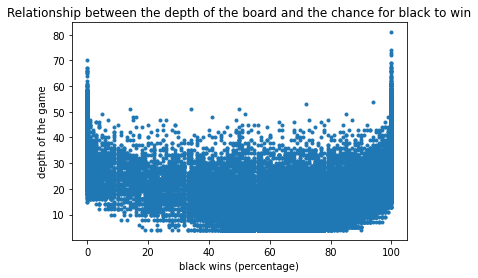

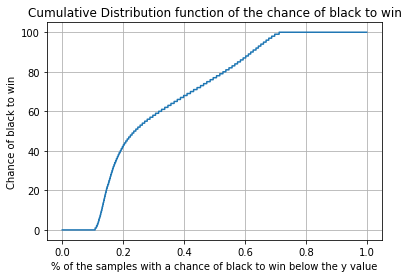

In [231]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Relationship between the depth of the board and the chance for black to win")
plt.plot([sample["black_wins"] for sample in data],[sample["depth"] for sample in data], '.')
plt.xlabel("black wins (percentage)")
plt.ylabel("depth of the game")


# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.grid()
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("% of the samples with a chance of black to win below the y value")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

# First steps: transform all the data into numpy arrays to feed your neural network

Advices:
- do not use only a 9x9 matrix as input. Use at least two planes to encode the board. One plane for black and one plane for white (typically with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane). The dimension of an input should be at least `[2,9,9]`. In Torch, the Conv2d method needs inputs as `[NBatch, Channels, H, W]`.
- consider to enrich your dataset with all symmetries and rotations. You should be able to multiply the number of samples to consider: any rotation of the board should have the same score, right?. You can use `np.rot90` to rotate your boards be beware of the dimensions (the channel is not the last dimension), so you may want to use `np.moveaxis()` to force the channels to be the last dimension, then call it again to make it the second one.
- what should happen on the score if you switch the colors? To know which player has to play next, you can check, for a sample, the parity of the length of the list `data[i]["list_of_moves"]` (an odd length list would mean that white is the next player. An even length list means that black has to play).
- work on enlarging and preparing your data only once. Once all you input data is setup as a big Numpy matrix, you may want to save it for speeding up everything. You can use, for instance `numpy.rot90()` and `numpy.flipud()` to generate all the symmetries



RENDU




La fonction `get_data` prépare les données pour l'apprentissage en :

- **Augmentant la variabilité** : En générant des données augmentées avec des transformations aléatoires.
- **Extrait et encode** : Les positions des pierres et les étiquettes de victoire pour chaque joueur.
- **Équilibre les classes** : Pour éviter tout biais dans l'apprentissage.
- **Mélange les données** : Pour introduire de l'aléatoire dans l'ordre des échantillons.


In [5]:
import torchvision.transforms as transforms
import numpy as np
import torch
def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

data_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

def augment_data(x):
    augmented_data = []
    for _ in range(6):
        channels = []
        for i in range(x.shape[0]): 
            tensor_x = torch.tensor(x[i], dtype=torch.float32)  
            tensor_x = tensor_x.unsqueeze(0)
            pil_image = transforms.ToPILImage()(tensor_x) 
            augmented_pil = data_transform(pil_image) 
            augmented_tensor = transforms.ToTensor()(augmented_pil)  
            channels.append(augmented_tensor.squeeze(0)) 
        augmented_data.append(torch.stack(channels).numpy())  

    return augmented_data

def get_data(data):
    X_black_wins = []
    Y_black_wins = []
    X_white_wins = []
    Y_white_wins = []

    for elt in data:
        x = np.zeros((2, 8, 8))
        for i, stone in enumerate(elt['list_of_moves']):
            if stone != 'PASS':
                x[i % 2, name_to_coord(stone)[0], name_to_coord(stone)[1]] = 1
        
        y_black = elt['black_wins'] / elt['rollouts']
        y_white = 1 - y_black

        augmentations = augment_data(x)
        
        if y_black > 0.5:
            for aug in augmentations:
                X_black_wins.append(aug)
                Y_black_wins.append([y_black])
        else:
            for aug in augmentations:
                X_white_wins.append(aug)
                Y_white_wins.append([y_white])
    len_black_wins = len(X_black_wins)
    len_white_wins = len(X_white_wins)
    
    if len_black_wins > len_white_wins:
        difference = len_black_wins - len_white_wins
        additional_white_samples = np.random.choice(len_white_wins, difference, replace=True)
        for index in additional_white_samples:
            X_white_wins.append(X_white_wins[index])
            Y_white_wins.append(Y_white_wins[index])
    else:
        difference = len_white_wins - len_black_wins
        additional_black_samples = np.random.choice(len_black_wins, difference, replace=True)
        for index in additional_black_samples:
            X_black_wins.append(X_black_wins[index])
            Y_black_wins.append(Y_black_wins[index])
    
    X_balanced = X_black_wins + X_white_wins
    Y_balanced = Y_black_wins + Y_white_wins
    combined = list(zip(X_balanced, Y_balanced))
    np.random.shuffle(combined)
    X_balanced, Y_balanced = zip(*combined)
    
    return np.array(X_balanced), np.array(Y_balanced)

X,Y = get_data(data)
print(X.shape, Y.shape)



(378240, 2, 8, 8) (378240, 1)


Spliting the data 

Ce code est crucial pour la préparation des données avant l'entraînement de notre modèle de réseau de neurones:

- **Division des données** : Les données sont segmentées en ensembles d'entraînement, de validation et de test
  
- **Réorganisation des données** : Les données sont remodelées pour correspondre au format attendu par PyTorch : chaque échantillon est une image de taille 8x8 avec 2 canaux.

- **Création de jeux de données** : Les données sont regroupées en jeux de données PyTorch à l'aide de la classe `TensorDataset`.

- **Création de chargeurs de données** : Des chargeurs de données (`DataLoader`) sont créés à partir des jeux de données. Ces chargeurs permettent d'itérer efficacement sur les données pendant l'entraînement du modèle.


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
from torch.utils.data import random_split,TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
from torchsummary import summary
import tqdm
import torch.nn.functional as F

device = 'cpu'

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.33)

X_train = X_train.reshape(X_train.shape[0],2,8,8)
X_val = X_val.reshape(X_val.shape[0],2,8,8)
X_test = X_test.reshape(X_test.shape[0],2,8,8)

train_data = TensorDataset(torch.from_numpy(X_train).to(device), torch.from_numpy(Y_train).to(device))
test_data = TensorDataset(torch.from_numpy(X_test).to(device), torch.from_numpy(Y_test).to(device))
train_loader = DataLoader(train_data, batch_size=200, shuffle=True)
test_loader = DataLoader(test_data, batch_size=200, shuffle=True)

# Second steps: build your neural network and train it

Don't forget to check overfitting, ...

*advices* :
- you may need to use some of the `torch.nn` layers: `Linear`, `Conv2d`, `ReLU`, `LeakyReLU`, `BatchNorm2d`, `Flatten`, `Dropout`... But you can of course first build a very simple one (and just pick some of them)...
- if you use convolution layers, be sure **not to downsize your board**. Applying a filter should keep the original size of the board (9x9), otherwise you would somehow forget the stones on the borders
- you will use like 33% of your input sample for validation. However, the final goal is to score new data that will be given in addition to the actual data. So, you should use the 33% splitting rule to set up your network architecture and, once you fixed it, you should train your final model on the whole set of data, crossing your fingers that it will generalize well.
- Warning: if you run a few epoch, and run it again for some more epochs, it will not reset the weights and the biases of your neural network. It's good news because you can add more and more epochs to your model, but be careful about the training/test sets (do split your sets before you initialize your model). Or you will be breaking your validation/training partition!


- **Couches de convolution** : Utilisation de `nn.Conv2d` pour extraire des caractéristiques spatiales des images.
- **Normalisation par lots** : `nn.BatchNorm2d` pour stabiliser l'entraînement et améliorer la généralisation.
- **Activation ReLU** : `nn.ReLU` introduit une non-linéarité pour apprendre des représentations complexes.
- **Couches entièrement connectées** : `nn.Linear` pour la classification finale avec des dimensions adaptées à la tâche.
- **Dropout** : `nn.Dropout` pour réduire le surajustement en désactivant aléatoirement des neurones.
- **Activation Sigmoid** : `nn.Sigmoid` produit une sortie dans l'intervalle [0, 1] pour la classification binaire.


In [8]:

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.fc_layers(x)
        return x


    

def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        test_loss = 0
        model.train()
        for inputs, targets in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()  
        total_test_samples = 0  
        with torch.no_grad():
            for inputs, targets in tqdm.tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                outputs = model(inputs.float())
                loss = criterion(outputs, targets.float().unsqueeze(1))
                test_loss += loss.item()
                total_test_samples += len(targets) 
        test_losses.append(test_loss / total_test_samples)  
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
    return train_losses, test_losses



La fonction `train_model` entraîne un modèle de réseau de neurones sur les données d'entraînement, évalue sa performance sur les données de test à chaque époque, calcule et affiche les pertes d'entraînement et de test pour surveiller l'entraînement et évaluer la performance du modèle.


Preparing the model



In [9]:
model = Network()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
summary(model, (2,8,8), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 32, 8, 8]             608
       BatchNorm2d-2             [-1, 32, 8, 8]              64
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
              ReLU-9            [-1, 128, 8, 8]               0
           Linear-10                  [-1, 512]       4,194,816
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
             ReLU-14                  [

Training


In [10]:
num_epochs = 10
train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs)


Epoch 1/10 - Training:   0%|                                                                    | 0/849 [00:00<?, ?it/s]/home/msandi/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/10 - Training: 100%|█████████████████████████████████████████████████████████▊| 847/849 [00:30<00:00, 20.30it/s]/home/msandi/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([191, 1, 1])) that is different to the input size (torch.Size([191, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/10 - Validation: 100%|████████

Epoch 1/10, Train Loss: 0.0362, Test Loss: 0.0002


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 112.21it/s]


Epoch 2/10, Train Loss: 0.0327, Test Loss: 0.0002


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 111.08it/s]


Epoch 3/10, Train Loss: 0.0321, Test Loss: 0.0002


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 112.46it/s]


Epoch 4/10, Train Loss: 0.0318, Test Loss: 0.0002


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 106.68it/s]


Epoch 5/10, Train Loss: 0.0316, Test Loss: 0.0002


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 107.85it/s]


Epoch 6/10, Train Loss: 0.0315, Test Loss: 0.0002


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 104.54it/s]


Epoch 7/10, Train Loss: 0.0314, Test Loss: 0.0002


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 104.27it/s]


Epoch 8/10, Train Loss: 0.0314, Test Loss: 0.0002


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:05<00:00, 107.06it/s]


Epoch 9/10, Train Loss: 0.0314, Test Loss: 0.0002


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████| 625/625 [00:05<00:00, 110.29it/s]

Epoch 10/10, Train Loss: 0.0314, Test Loss: 0.0002


Saving

In [11]:
torch.save(model, 'death.pth')

Graphe


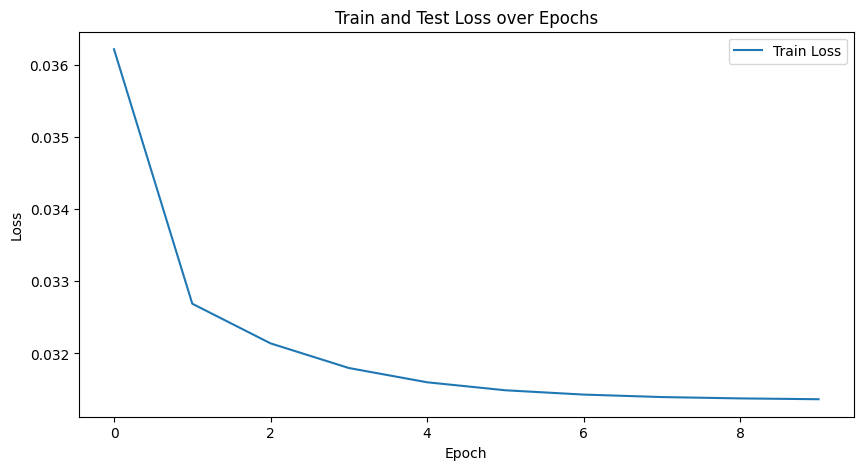

In [15]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()

# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...

In [13]:
def get_raw_data_go():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "positions-to-evaluate-8x8.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/static/inge2-ia/positions-to-evaluate-8x8.json.gz", "positions-to-evaluate-8x8.json.gz")
        print(" Done")

    with gzip.open("positions-to-evaluate-8x8.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go()
print("We have", len(data),"positions")


def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    with open("my_predictions.txt", "w") as f:
        for d in newdata:
            prediction = position_predict(d["black_stones"], d["white_stones"])
            f.write(str(prediction.item()) + "\n")

create_result_file(data)


File positions-to-evaluate-8x8.json.gz not found, I am downloading it... Done
We have 1000 positions


NameError: name 'position_predict' is not defined